In [5]:
import random
from itertools import count

# from tqdm.notebook import tqdm
from tqdm.auto import tqdm         # safest single-line fix
from sublementary.Mars_Rover_env import MarsRoverEnv

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

gamma = 1

pi_history = []
vi_history = []


In [6]:
def rmse(x, y, dp=4):
    return np.round(np.sqrt(np.mean((x - y) ** 2)), dp)

def policy_evaluation(env, policy, state_value=None):
    """Inplace policy evaluation. The existence and uniqueness of v are guaranteed as long as either gamma  < 1
        or eventual termination is guaranteed from all states under the policy pi. We have to exclude actions which
        lead to an infinite horizon or set gamma < 1 """
    if state_value is None:
        # initialize value table with zeros
        state_value = np.zeros(env.observation_space.n)

    # set the threshold
    threshold = 1e-20
    max_number_sweeps = 20000

    for sweep_nr in range(max_number_sweeps):
        delta = 0
        # for each state in the environment, select the action according to the policy and compute the value table
        for state in env.P:
            v = state_value[state]
            # action = policy[state]
            action = policy(state)
            # build the value table with the selected action
            state_value[state] = sum([trans_prob * (reward +
                                                    gamma * (
                                                            state_value[next_state] * (1 - done)))
                                      for trans_prob, next_state, reward, done in env.P[state][action]])
            delta = max(delta, abs(v - state_value[state]))
        if delta < threshold: break

    return state_value, sweep_nr

def learn_rate_decay_schedule(init_value, min_value, decay_ratio, max_steps, log_start=-2, log_base=10):
    decay_steps = int(max_steps * decay_ratio)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min()) / (values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    values = np.pad(values, (0, rem_steps), 'edge')
    return values

def generate_trajectory(pi, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()
        for t in count():
            action = pi(state)
            next_state, reward, done, _ = env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state
    return np.array(trajectory, object)

def print_state_value_function(V, P, n_cols=4, prec=3, title='State-value function:'):
    print(title)
    for s in range(len(P)):
        v = V[s]
        print("| ", end="")
        if np.all([done for action in P[s].values() for _, _, _, done in action]):
            print("".rjust(9), end=" ")
        else:
            print(str(s).zfill(2), '{}'.format(np.round(v, prec)).rjust(6), end=" ")
        if (s + 1) % n_cols == 0: print("|")

import numpy as np
from tqdm.auto import tqdm


In [7]:
# ---------------------------------------------------------------------
#  Monte-Carlo state-value prediction (first-visit by default)
# ---------------------------------------------------------------------
def mc_prediction(pi,
                  env,
                  gamma: float = 1.0,
                  init_alpha: float = 0.5,
                  min_alpha: float = 0.01,
                  alpha_decay_ratio: float = 0.5,
                  n_episodes: int = 500,
                  max_steps: int = 200,
                  first_visit: bool = True,
                  **kwargs):
    """
    First-visit or every-visit Monte-Carlo prediction of V^pi.

    Parameters
    ----------
    pi : Callable[[int], int]
        Deterministic policy mapping state -> action.
    env : gym.Env
        Environment following the OpenAI-Gym API.
    gamma : float
        Discount factor.
    init_alpha, min_alpha, alpha_decay_ratio : float
        Parameters for a decaying learning-rate schedule unless
        `constant_alpha` is supplied in **kwargs.
    n_episodes : int
        Number of episodes to sample.
    max_steps : int
        Per-episode trajectory cap.
    first_visit : bool
        If True, use first-visit MC; otherwise every-visit.
    **kwargs
        constant_alpha : float – use a fixed step-size.
        init_V : float   – initial value for all non-terminal states.

    Returns
    -------
    V : ndarray, shape (nS,)
        Estimated state-value function after `n_episodes`.
    V_track : ndarray, shape (n_episodes+1, nS)
        Snapshot of V after episode 0 (initial) and after each episode.
    targets : dict[int, list[float]]
        All returns (targets) seen for every state.
    """
    nS = env.observation_space.n
    discounts = np.logspace(0, max_steps, num=max_steps,
                            base=gamma, endpoint=False)

    # learning-rate schedule
    if 'constant_alpha' in kwargs:
        alphas = np.full(n_episodes, kwargs['constant_alpha'])
    else:
        alphas = learn_rate_decay_schedule(init_alpha,
                                           min_alpha,
                                           alpha_decay_ratio,
                                           n_episodes)

    V_init = kwargs.get('init_V', 0.0)
    V = np.full(nS, V_init, dtype=np.float64)
    V[0] = V[nS - 1] = 0.0                                   # terminals

    V_track = np.zeros((n_episodes + 1, nS), dtype=np.float64)
    V_track[0] = V                                           # episode-0 snapshot

    targets = {s: [] for s in range(nS)}

    for e in tqdm(range(n_episodes), leave=False):
        trajectory = generate_trajectory(pi, env, max_steps)
        visited = np.zeros(nS, dtype=bool)

        for t, (state, _, reward, _, _) in enumerate(trajectory):
            if first_visit and visited[state]:
                continue
            visited[state] = True

            n_steps = len(trajectory) - t
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])  # return
            targets[state].append(G)

            V[state] += alphas[e] * (G - V[state])               # MC update

        V_track[e + 1] = V                                       # after episode e

    return V.copy(), V_track, targets



In [8]:
# ---------------------------------------------------------------------
#  TD(0) state-value prediction
# ---------------------------------------------------------------------
def td(pi,
       env,
       gamma: float = 1.0,
       init_alpha: float = 0.5,
       min_alpha: float = 0.01,
       alpha_decay_ratio: float = 0.5,
       n_episodes: int = 500,
       **kwargs):
    """
    TD(0) prediction of V^pi with optional constant or decaying step-size.

    Parameters mirror `mc_prediction` (minus `max_steps`, `first_visit`).
    """
    nS = env.observation_space.n

    if 'constant_alpha' in kwargs:
        alphas = np.full(n_episodes, kwargs['constant_alpha'])
    else:
        alphas = learn_rate_decay_schedule(init_alpha,
                                           min_alpha,
                                           alpha_decay_ratio,
                                           n_episodes)

    V_init = kwargs.get('init_V', 0.0)
    V = np.full(nS, V_init, dtype=np.float64)
    V[0] = V[nS - 1] = 0.0                                     # terminals

    V_track = np.zeros((n_episodes + 1, nS), dtype=np.float64)
    V_track[0] = V                                             # episode-0 snapshot

    targets = {s: [] for s in range(nS)}

    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset(), False
        while not done:
            action = pi(state)
            next_state, reward, done, _ = env.step(action)

            td_target = reward + gamma * V[next_state] * (not done)
            targets[state].append(td_target)

            V[state] += alphas[e] * (td_target - V[state])
            state = next_state

        V_track[e + 1] = V                                      # after episode e

    return V.copy(), V_track, targets

#
# def mc_prediction(pi,
#                   env,
#                   gamma=1.0,
#                   init_alpha=0.5,
#                   min_alpha=0.01,
#                   alpha_decay_ratio=0.5,
#                   n_episodes=500,
#                   max_steps=200,
#                   first_visit=True,
#                   **kwargs):
#     nS = env.observation_space.n
#     discounts = np.logspace(0,
#                             max_steps,
#                             num=max_steps,
#                             base=gamma,
#                             endpoint=False)
#     if 'constant_alpha' in kwargs:
#         alphas = np.ones(n_episodes) * kwargs.get('constant_alpha')
#     else:
#         alphas = learn_rate_decay_schedule(init_alpha,
#                                            min_alpha,
#                                            alpha_decay_ratio,
#                                            n_episodes)
#     V_init = kwargs.get('init_V') if 'init_V' in kwargs else 0
#
#     V = np.ones(nS, dtype=np.float64) * V_init  # inits of V
#     V[0] = V[nS - 1] = 0
#     V_track = np.zeros((n_episodes, nS), dtype=np.float64)
#     targets = {state: [] for state in range(nS)}
#
#     for e in tqdm(range(n_episodes), leave=False):
#         trajectory = generate_trajectory(pi,
#                                          env,
#                                          max_steps)
#         visited = np.zeros(nS, dtype=bool)
#         for t, (state, _, reward, _, _) in enumerate(trajectory):
#             if visited[state] and first_visit:
#                 continue
#             visited[state] = True
#
#             n_steps = len(trajectory[t:])
#             G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
#             targets[state].append(G)
#             mc_error = G - V[state]
#             V[state] = V[state] + alphas[e] * mc_error
#         V_track[e] = V
#     return V.copy(), V_track, targets
#
#
# def td(pi,
#        env,
#        gamma=1.0,
#        init_alpha=0.5,
#        min_alpha=0.01,
#        alpha_decay_ratio=0.5,
#        n_episodes=500, **kwargs):
#     nS = env.observation_space.n
#     V_init = kwargs.get('init_V') if 'init_V' in kwargs else 0
#     V = np.ones(nS, dtype=np.float64) * V_init  # inits of V
#     V[0] = V[nS - 1] = 0
#     V_track = np.zeros((n_episodes, nS), dtype=np.float64)
#     targets = {state: [] for state in range(nS)}
#     if 'constant_alpha' in kwargs:
#         alphas = np.ones(n_episodes) * kwargs.get('constant_alpha')
#     else:
#         alphas = learn_rate_decay_schedule(init_alpha,
#                                            min_alpha,
#                                            alpha_decay_ratio,
#                                            n_episodes)
#     for e in tqdm(range(n_episodes), leave=False):
#         state, done = env.reset(), False
#         while not done:
#             action = pi(state)
#             next_state, reward, done, _ = env.step(action)
#             td_target = reward + gamma * V[next_state] * (not done)
#             targets[state].append(td_target)
#             td_error = td_target - V[state]
#             V[state] = V[state] + alphas[e] * td_error
#             state = next_state
#         V_track[e] = V
#     return V, V_track, targets
#

In [9]:
def plot_value_function(title, V_track, V_true=None, log=False, limit_value=0.05, limit_items=7):
    np.random.seed(123)
    per_col = 25
    linecycler = cycle(["-", "--", ":", "-."])
    colorcycler = cycle(["lime", "blue", "dodgerblue", "red", 'orange', 'orange'])
    legends = []

    valid_values = np.argwhere(V_track[-1] > limit_value).squeeze()
    items_idxs = np.random.choice(valid_values,
                                  min(len(valid_values), limit_items),
                                  replace=False)
    plt.figure(figsize=(8, 5))
    # draw the true values first
    if V_true is not None:
        for i, state in enumerate(V_track.T):
            if i not in items_idxs:
                continue
            if state[-1] < limit_value:
                continue

            label = f'v({i})'
            color = next(colorcycler)
            plt.axhline(y=V_true[i], linestyle='-', linewidth=1, color=color)

    colorcycler = cycle(["lime", "blue", "dodgerblue", "red", 'orange', 'orange'])
    # then the estimates
    for i, state in enumerate(V_track.T):
        if i not in items_idxs:
            continue
        if state[-1] < limit_value:
            continue
        line_type = next(linecycler)
        color = next(colorcycler)
        label = 'V({})'.format(i)
        p, = plt.plot(state, ls=line_type, label=label, linewidth=1, color=color)
        legends.append(p)

    legends.reverse()

    ls = []
    for loc, idx in enumerate(range(0, len(legends), per_col)):
        subset = legends[idx:idx + per_col]
        l = plt.legend(subset, [p.get_label() for p in subset],
                       loc='center right', bbox_to_anchor=(1.25, 0.5))
        ls.append(l)
    [plt.gca().add_artist(l) for l in ls[:-1]]
    if log: plt.xscale('log')
    plt.title(title)
    plt.ylabel('Value Function')
    plt.xlabel('Episodes (log scale)' if log else 'Episodes')
    plt.tight_layout()
    plt.show()


def plot_targets(targets, init_state, title):
    x = range(len(targets[init_state]))
    y = targets[init_state]

    label = 'v({})'.format(init_state)
    plt.axhline(y=V_true[init_state], color='k', linestyle='-', linewidth=1)
    plt.text(int(x[-1] * 1.02), V_true[init_state] + .01, label)

    plt.scatter(x, y,
                c=np.array(targets[init_state]),
                cmap=plt.get_cmap('viridis'),
                alpha=0.4)
    plt.title(title)

    plt.ylabel('Target value')
    plt.xlabel('Estimate sequence number')
    plt.show()





In [10]:
SEEDS = range(100)

[0.  2.5 4.  5.5 7.  8.5 0. ]


  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          |

State-value function:
|           | 01  2.518 | 02   4.05 | 03  5.552 | 04   7.01 | 05  8.493 |           |


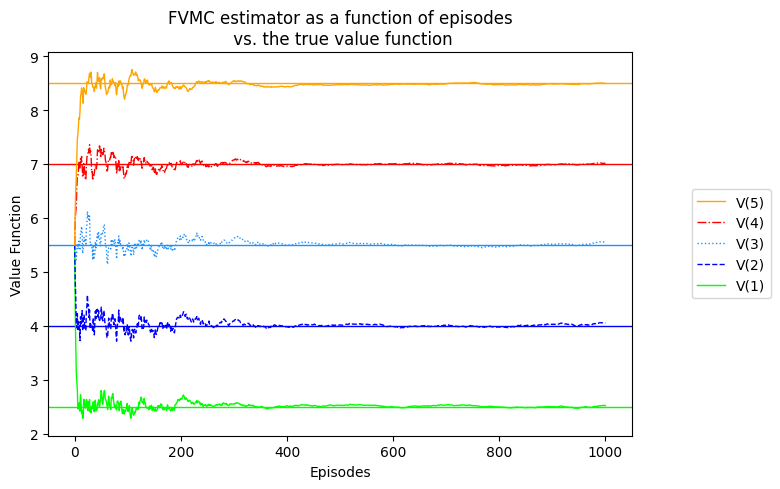

RMSE FVMC learning: 0.0284


  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          | 0/1000 [00:00<?, ?it/s]
                                        
  0%|          |

State-value function:
|           | 01  2.521 | 02  4.059 | 03  5.584 | 04  7.089 | 05  8.565 |           |

State-value function errors:
|           | 01  0.021 | 02  0.059 | 03  0.084 | 04  0.089 | 05  0.065 |           |
RMSE TD learning: 0.0575


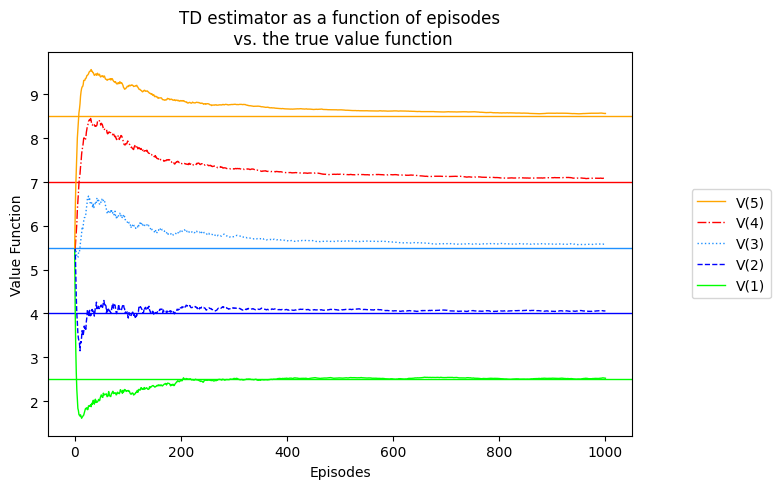

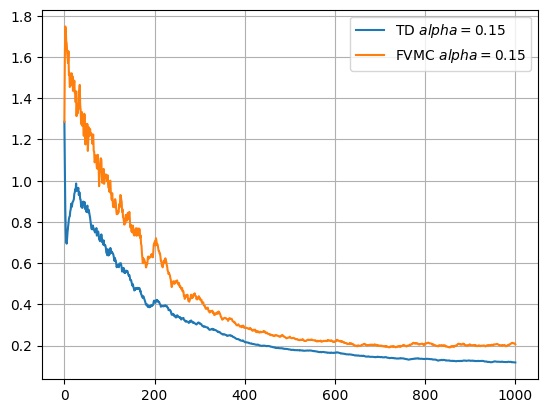

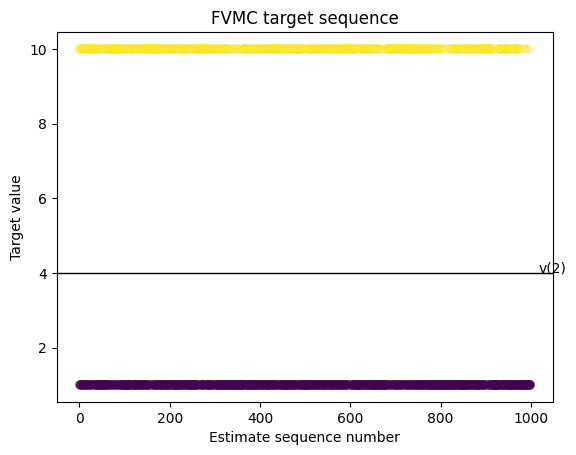

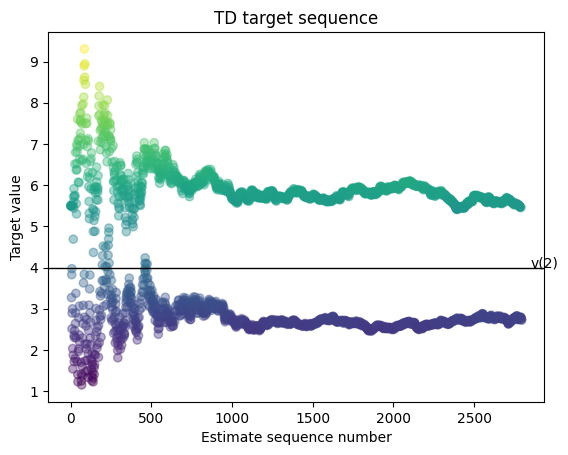

  0%|          | 0/100 [00:00<?, ?it/s]
                                       
  0%|          | 0/100 [00:00<?, ?it/s]
                                       
  0%|          | 0/100 [00:00<?, ?it/s]
                                       
  0%|          | 0/100 [00:00<?, ?it/s]
                                       
  0%|          | 0/100 [00:00<?, ?it/s]
                                       
  0%|          | 0/100 [00:00<?, ?it/s]
                                       
  0%|          | 0/100 [00:00<?, ?it/s]
                                       
  0%|          | 0/100 [00:00<?, ?it/s]
                                       
  0%|          | 0/100 [00:00<?, ?it/s]
                                       
  0%|          | 0/100 [00:00<?, ?it/s]
                                       
  0%|          | 0/100 [00:00<?, ?it/s]
                                       
  0%|          | 0/100 [00:00<?, ?it/s]
                                       
  0%|          | 0/100 [00:00<?, ?it/s]


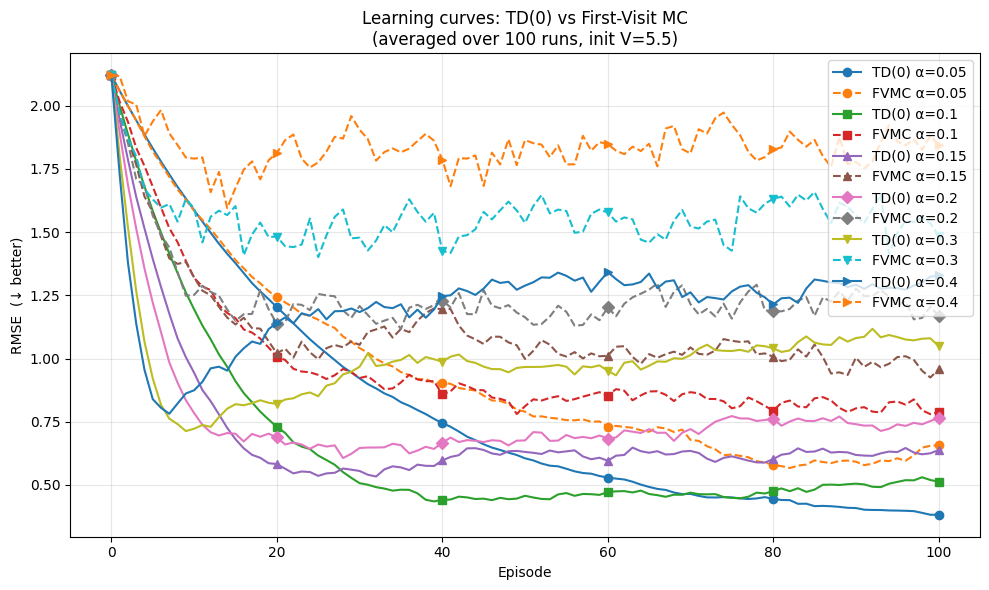

  0%|          | 0/300 [00:00<?, ?it/s]
                                       
  0%|          | 0/300 [00:00<?, ?it/s]
                                       
  0%|          | 0/300 [00:00<?, ?it/s]
                                       
  0%|          | 0/300 [00:00<?, ?it/s]
                                       
  0%|          | 0/300 [00:00<?, ?it/s]
                                       
  0%|          | 0/300 [00:00<?, ?it/s]
                                       
  0%|          | 0/300 [00:00<?, ?it/s]
                                       
  0%|          | 0/300 [00:00<?, ?it/s]
                                       
  0%|          | 0/300 [00:00<?, ?it/s]
                                       
  0%|          | 0/300 [00:00<?, ?it/s]
                                       
  0%|          | 0/300 [00:00<?, ?it/s]
                                       
  0%|          | 0/300 [00:00<?, ?it/s]
                                       
  0%|          | 0/300 [00:00<?, ?it/s]


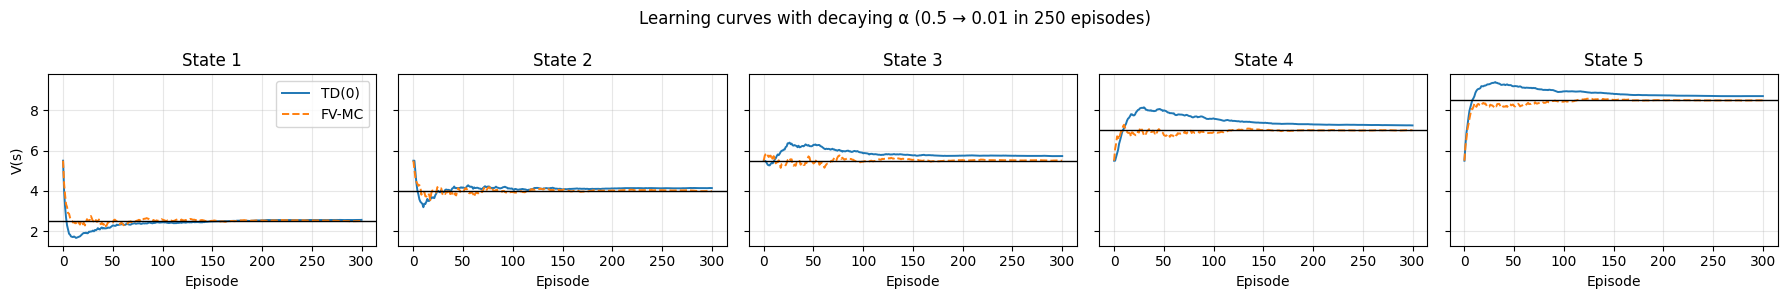

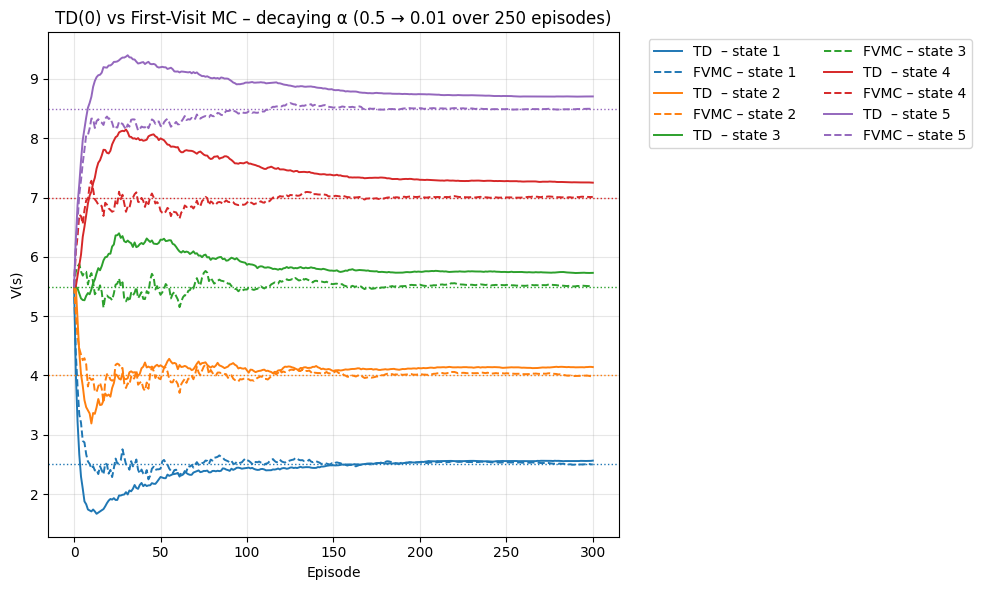

In [15]:
if __name__ == '__main__':

    env = MarsRoverEnv(n_states=5, p_backward=0.5, p_stay=0)

    LEFT, RIGHT = range(2)
    pi = lambda s: {
        0: LEFT, 1: LEFT, 2: LEFT, 3: LEFT, 4: LEFT, 5: LEFT, 6: LEFT
    }[s]

    # we use policy_evaluation here, are there alternatives?
    V_true = policy_evaluation(env, pi)[0]
    print(V_true)
    constant_alpha_mc = 0.15
    constant_alpha_td = 0.15
    V_init = 5.5

    init_state = env.reset()

    gamma = 1.0
    n_episodes = 1000
    P = env.P

    V_fvmcs, V_track_fvmcs = [], []
    for seed in tqdm(SEEDS, desc='All seeds', leave=True):
        random.seed(seed);
        np.random.seed(seed);
        env.seed(seed)
        V_fvmc, V_track_fvmc, targets_fvmc = mc_prediction(pi, env, gamma=gamma, n_episodes=n_episodes,
                                                           # constant_alpha=constant_alpha_mc,
                                                           init_V=V_init)
        V_fvmcs.append(V_fvmc);
        V_track_fvmcs.append(V_track_fvmc)
    V_fvmc, V_track_fvmc = np.mean(V_fvmcs, axis=0), np.mean(V_track_fvmcs, axis=0)

    print_state_value_function(V_fvmc, P, n_cols=7)
    plot_value_function('FVMC estimator as a function of episodes\n vs. the true value function',
                        V_track_fvmc, V_true, log=False)
    print('RMSE FVMC learning:', rmse(V_fvmc, V_true))

    V_tds, V_track_tds = [], []
    for seed in tqdm(SEEDS, desc='All seeds', leave=True):
        random.seed(seed);
        np.random.seed(seed);
        env.seed(seed)

        V_td, V_track_td, targets_td = td(pi, env, gamma=gamma, n_episodes=n_episodes,
                                          # constant_alpha=constant_alpha_td,
                                          init_V=V_init)
        V_tds.append(V_td);
        V_track_tds.append(V_track_td)

    V_td, V_track_td = np.mean(V_tds, axis=0), np.mean(V_track_tds, axis=0)

    print_state_value_function(V_td, P, n_cols=7)
    print()
    print_state_value_function(V_td - V_true, P, n_cols=7, title='State-value function errors:')
    print('RMSE TD learning:', rmse(V_td, V_true))

    plot_value_function('TD estimator as a function of episodes\n vs. the true value function', V_track_td, V_true,
                        log=False)

    plt.plot(np.mean(np.sqrt(np.mean((V_track_tds - V_true) ** 2, axis=0)), axis=1),
             label=f'TD $alpha=${constant_alpha_td}')
    plt.plot(np.mean(np.sqrt(np.mean((V_track_fvmcs - V_true) ** 2, axis=0)), axis=1),
             label=f'FVMC $alpha=${constant_alpha_mc}')
    plt.legend()
    plt.grid()
    plt.show()

    plot_targets(targets_fvmc, init_state, title='FVMC target sequence')

    plot_targets(targets_td, init_state, title='TD target sequence')


 # ------------------------------------------------------------
    # experiment parameters
    # ------------------------------------------------------------
    ALPHAS        = [0.05, 0.10, 0.15, 0.20, 0.30, 0.40]   # constant step-sizes to compare
    N_EPISODES    = 100                  # length of each learning curve
    N_RUNS        = 100                  # Monte-Carlo repetitions
    GAMMA         = 1.0
    INIT_V        = 5.5

    LEFT, RIGHT = range(2)
    pi = lambda s: {0: LEFT, 1: LEFT, 2: LEFT, 3: LEFT, 4: LEFT, 5: LEFT, 6: LEFT}[s]

    # ------------------------------------------------------------
    # reference value function (exact policy evaluation)
    # ------------------------------------------------------------
    V_ref, _ = policy_evaluation(env, pi)

    non_terminal = [s for s in range(env.observation_space.n) if s not in (0, env.observation_space.n-1)]

    def run_method(method, alpha):
        """
        Run one TD or FVMC trial and return the per-episode RMSE vector.
        """
        V, V_track, _ = method(
            pi, env,
            gamma=GAMMA,
            n_episodes=N_EPISODES,
            constant_alpha=alpha,
            init_V=INIT_V
        )
        # V_track has shape (N_EPISODES+1, nS); skip the first row if you
        # don't want episode-0 in the RMSE curve.
        err = np.sqrt(
            ((V_track[:, non_terminal] - V_ref[non_terminal]) ** 2).mean(axis=1)
        )
        return err

    # ------------------------------------------------------------
    # main loop: average over runs
    # ------------------------------------------------------------
    rmse_td   = {α: np.zeros(N_EPISODES+1) for α in ALPHAS}
    rmse_mc   = {α: np.zeros(N_EPISODES+1) for α in ALPHAS}

    for run in tqdm(range(N_RUNS), desc='Runs'):
        # new random seeds each run (optional):
        np.random.seed(run)
        env.seed(run)

        for α in ALPHAS:
            rmse_td[α] += run_method(td,         α)
            rmse_mc[α] += run_method(mc_prediction, α)

    # average
    for α in ALPHAS:
        rmse_td[α] /= N_RUNS
        rmse_mc[α] /= N_RUNS

    # ------------------------------------------------------------
    # plot
    # ------------------------------------------------------------
    plt.figure(figsize=(10, 6))

    from itertools import cycle

    marker_cycle = cycle(['o', 's', '^', 'D', 'v', '>', '<', 'p', 'h'])
    markers = {α: next(marker_cycle) for α in ALPHAS}

    for α in ALPHAS:
        plt.plot(rmse_td[α],  label=f'TD(0) α={α}',  marker=markers[α], markevery=20, linewidth=1.5)
        plt.plot(rmse_mc[α],  label=f'FVMC α={α}',  linestyle='--',    marker=markers[α], markevery=20)

    plt.xlabel('Episode')
    plt.ylabel('RMSE  (↓ better)')
    plt.title('Learning curves: TD(0) vs First-Visit MC\n(averaged over 100 runs, init V=5.5)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ──────────────────────────────────────────────────────────────────────────
    #   Per-state learning curves – decaying α   (TD(0)  vs  First-Visit MC)
    # ──────────────────────────────────────────────────────────────────────────
    import numpy as np
    import matplotlib.pyplot as plt
    from tqdm.auto import trange  # progress bar

    # experiment settings
    N_EPISODES = 300
    INIT_ALPHA = 0.5
    MIN_ALPHA = 0.01
    DECAY_STEPS = 250
    ALPHA_RATIO = DECAY_STEPS / N_EPISODES  # = 0.5
    N_RUNS = 100
    GAMMA = 1.0
    INIT_V = 5.5

    # environment & policy
    env = MarsRoverEnv(n_states=5, p_backward=0.5, p_stay=0)
    LEFT, RIGHT = range(2)
    π = lambda s: {0: LEFT, 1: LEFT, 2: LEFT, 3: LEFT, 4: LEFT, 5: LEFT, 6: LEFT}[s]

    # “ground-truth” value function (exact policy evaluation)
    V_true, _ = policy_evaluation(env, π)

    nS = env.observation_space.n
    non_terminal = [s for s in range(nS) if s not in (0, nS - 1)]  # five states

    track_td = np.zeros((N_EPISODES + 1, nS))
    track_mc = np.zeros_like(track_td)

    # Monte-Carlo repetitions
    for run in trange(N_RUNS, desc='runs'):
        np.random.seed(run);
        env.seed(run)

        _, Vtrack_td, _ = td(π, env,
                             gamma=GAMMA,
                             init_alpha=INIT_ALPHA,
                             min_alpha=MIN_ALPHA,
                             alpha_decay_ratio=ALPHA_RATIO,
                             n_episodes=N_EPISODES,
                             init_V=INIT_V)

        _, Vtrack_mc, _ = mc_prediction(π, env,
                                        gamma=GAMMA,
                                        init_alpha=INIT_ALPHA,
                                        min_alpha=MIN_ALPHA,
                                        alpha_decay_ratio=ALPHA_RATIO,
                                        n_episodes=N_EPISODES,
                                        init_V=INIT_V)

        track_td += Vtrack_td
        track_mc += Vtrack_mc

    track_td /= N_RUNS
    track_mc /= N_RUNS

    # ─── plotting ────────────────────────────────────────────────────────────
    fig, axes = plt.subplots(1, len(non_terminal), figsize=(18, 3), sharey=True)

    for ax, s in zip(axes, non_terminal):
        ax.plot(track_td[:, s], label='TD(0)', linewidth=1.4)
        ax.plot(track_mc[:, s], label='FV-MC', linestyle='--', linewidth=1.4)
        ax.axhline(V_true[s], color='k', linewidth=1)  # true V
        ax.set_title(f'State {s}')
        ax.set_xlabel('Episode')
        ax.grid(alpha=.3)

    axes[0].set_ylabel('V(s)')
    axes[0].legend(loc='upper right')
    fig.suptitle('Learning curves with decaying α (0.5 → 0.01 in 250 episodes)')
    plt.tight_layout()
    plt.show()

    # ─── One–figure summary: all five states on the same axes ────────────────
    plt.figure(figsize=(10, 6))

    colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

    for k, s in enumerate(non_terminal):
        plt.plot(track_td[:, s],
                 color=colors[k],
                 linewidth=1.4,
                 label=f'TD  – state {s}')
        plt.plot(track_mc[:, s],
                 color=colors[k],
                 linestyle='--',
                 linewidth=1.4,
                 label=f'FVMC – state {s}')
        plt.axhline(V_true[s],
                    color=colors[k],
                    linestyle=':',
                    linewidth=1)

    plt.xlabel('Episode')
    plt.ylabel('V(s)')
    plt.title('TD(0) vs First-Visit MC – decaying α (0.5 → 0.01 over 250 episodes)')
    plt.grid(alpha=.3)
    plt.legend(ncol=2, bbox_to_anchor=(1.04, 1), loc='upper left')
    plt.tight_layout()
    plt.show()